# <div align="center">Data Fusion Architecture - Localisation Assignment</div>

<div align="center">By Artem Vorobiov, Justin Spethmann, Vance Madadianshourkaei</div>



<center><img src="one.jpeg"/></center>

## Table of contents:
1. Robot Analysis
2. Rosbags info
3. Functions needed for Particle filter assembly
4. Calculate time stamps 
5. Calculate TF (sample sizing the data of position)
6. Orientation calculation 
7. Imu velocity
8. First particle filter (without std)
9. Second particle filter (imu)
10. Calculate velocity (wheel encoders)
11. Third Particle filters (wheel encoders)
12. Fusion (encoders and imu velocity) with Kalman Filter and implementation in the Particle Filter
13. Error Propagation
14. Conclusion

 

## Assessment criterias:
1. Apply Bayesian inference to fuse sensor data - **PART 3** contains a plausible mathematical model for Bayesian inference.
2. Create software implementing Bayesian inference in a sensor system - **PART 12** Bayesian inference is correctly implemented in code.
3. Analyse system requirements to identify applicable sensor fusion architectures - **REPORT** explains what kind of architectures are used and **PART 12** is the implementation of the architectures.
4. Apply error propagation techniques - **PART 13** in the end of it we make a conclusion based on error analysis.

# <div align="center">Part 1. Robot Analysis</div>

The concept of localisation is an issue that all autonomous mobile robots must solve in order to navigate its environment. Data from different sensors attached to a robot can be processed and fused to show its location. The sensor data can be separated into two types, predicting its movement, and perceiving its environment. The robot odometry shows the distance the robot moves, and sensors measuring external features can perceive the environment and compare if the distance from the robot to objects matches the predicted movement.

<center><img src="two.jpeg"/></center>

This assignment works with data collected from the sensor system of the iRobot create3, an educational model of the autonomous mobile vacuum cleaner. Using ROS2 the output of the various sensors of the robot can be accessed. The available sensor data are:

-	Battery state
-	Audio
-	Led lights
-	Hazard detection bumper
-	Internal measurement unit (IMU)
-	Interface buttons
-	Infrared intensity vectors
-	Kidnap status
-	Mouse
-	Odometry
-	Wheel encoders 

The sensors most relevant for the robot localization are the wheel encoders, the internal measurement unit (IMU) and the odometry. The wheel encoders can provide an angular velocity value, which can be converted into a linear velocity and with time stamps turned into a position estimation. The IMU provides the robots linear acceleration, which can be converted to velocity and position. The odometry represents a fused position reading created for the robot. 

In testing the infrared sensors proved to not be capable of observing the robot surroundings. They only create data for objects very close to the robot and cannot accurately create a distance reading. These sensors are the only way for this robot to perceive its environment. Since they are not sufficient for the assignment, the robot will compare its estimated position in code to theoretical landmarks and the position estimation of the already existing odometry. 




# <div align="center">Part 2. Rosbags info</div>
### <div align="center">Prepare readings from Rosbag</div>

#### <div align="center">Rosbag readings - part 1</div>

Using rosbags the sensor data was collected in a db3 file format. This format had to be read and converted in python into a format that can be manipulated and displays. 

Python cannot read db3 files. The following block of code creates an interpreter by creating a msg function that will compare the data from rosbags to the name within the msg variable and from there know where to extract the data to. Additionally, the relevant rosbag extensions necessary to read the data are imported. 



In [134]:
# Comment
from pathlib import Path
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
from rosbags.typesys import get_types_from_msg, register_types
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.transforms import Affine2D
import matplotlib as mpl

In [135]:
"""Register irobot custom msg format"""
# Create a dict for storing data
add_types = {}

# This part we need for getting access to Msgs. These are special architecture that allows to iterate over Rosbags data.
msgs = [{'path' : './msg/WheelTicks.msg', 'type' : 'irobot_create_msgs/msg/WheelTicks'},
        {'path' : './msg/WheelVels.msg', 'type' : 'irobot_create_msgs/msg/WheelVels'}]


for msg in msgs:
    msgpath = Path(msg['path'])
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, msg['type']))

register_types(add_types)
# Type import works only after the register_types call,
# the classname is derived from the msgtype names above.

# pylint: disable=no-name-in-module,wrong-import-position
from rosbags.typesys.types import irobot_create_msgs__msg__WheelTicks as WheelTicks  # type: ignore  # noqa
from rosbags.typesys.types import irobot_create_msgs__msg__WheelVels as WheelVels  # type: ignore  # noqa

# pylint: enable=no-name-in-module,wrong-import-position

#### <div align="center">Rosbag readings - part 2</div>

In the following step empty lists are created for each type of data relevant from the rosbag data. Generally, each sensor contains some form of sensor reading data along with a timestamp that can be in seconds or nanoseconds. 



In [136]:
# Create empty lists where we are going to store our readings from a robot.

# Reading from Wheel Encoders
wheelvel_right = []
wheelvel_left = []
SECOND = []
NANOSECOND = []

# Reading from in-build function that tracs the real direction of a robot.
TF_sec = []
TF_nsec = []
tf_vector_x = []
tf_vector_y = []
tf_vector_z = []
tf_quaternion_x = [] 
tf_quaternion_y = []
tf_quaternion_z = []
tf_quaternion_w = []

# Readings from IMU
imu_sec = []
imu_nanosec = []
imu_orientation_x = []
imu_orientation_y = []
imu_orientation_z = []
imu_orientation_w = []
imu_angular_velocity_x = []
imu_angular_velocity_y = []
imu_angular_velocity_z = []
imu_linear_acceleration_x = []
imu_linear_acceleration_y = []
imu_linear_acceleration_z = []

#### <div align="center">Rosbag readings - part 3</div>

With a reader function this block reads the type of data from the rosbags and compares it to the created msg variable. Based on the name it will append the data from rosbags into the respective empty lists created in the previous step. 

In [137]:


# create reader instance and open for reading
with Reader('turnLeft') as reader:
    for connection, timestamp, rawdata in reader.messages():
            
        # Connect to IMU sensor data and store information into create arrays
        if connection.msgtype == 'sensor_msgs/msg/Imu':
            msg = deserialize_cdr(rawdata, connection.msgtype)
            entry = {'timestamp': timestamp, 'msg': msg}
            
            
            imu_sec.append(entry["msg"].header.stamp.sec)
            imu_nanosec.append(entry["msg"].header.stamp.nanosec)
            imu_orientation_x.append(entry["msg"].orientation.x)
            imu_orientation_y.append(entry["msg"].orientation.y)
            imu_orientation_z.append(entry["msg"].orientation.z)
            imu_orientation_w.append(entry["msg"].orientation.w)
            imu_angular_velocity_x.append(entry["msg"].angular_velocity.x)
            imu_angular_velocity_y.append(entry["msg"].angular_velocity.y)
            imu_angular_velocity_z.append(entry["msg"].angular_velocity.z)
            imu_linear_acceleration_x.append(entry["msg"].linear_acceleration.x)
            imu_linear_acceleration_y.append(entry["msg"].linear_acceleration.y)
            imu_linear_acceleration_z.append(entry["msg"].linear_acceleration.z)
  

        # Connect to TF sensor data and store information into create arrays 
        elif connection.msgtype == 'tf2_msgs/msg/TFMessage':

            msg = deserialize_cdr(rawdata, connection.msgtype)
            entry = {'timestamp': timestamp, 'msg': msg}
            TF_sec.append(entry["msg"].transforms[0].header.stamp.sec)
            TF_nsec.append(entry["msg"].transforms[0].header.stamp.nanosec)      
            entry = {'timestamp': timestamp, 'msg': msg.transforms[1].transform}
            tf_vector_x.append(entry["msg"].translation.x)
            tf_vector_y.append(entry["msg"].translation.y)
            tf_vector_z.append(entry["msg"].translation.z)
            tf_quaternion_x.append(entry["msg"].rotation.x)
            tf_quaternion_y.append(entry["msg"].rotation.y)
            tf_quaternion_z.append(entry["msg"].rotation.z)
            tf_quaternion_w.append(entry["msg"].rotation.w)
   
            
        # Connect to Encoders sensor data and store information into create arrays 
        elif connection.msgtype == 'irobot_create_msgs/msg/WheelVels':
            msg = deserialize_cdr(rawdata, connection.msgtype)
            entry = {'timestamp': timestamp, 'msg': msg}
            wheelvel_left.append(entry["msg"].velocity_left)
            wheelvel_right.append(entry["msg"].velocity_right)
            SECOND.append(entry["msg"].header.stamp.sec)
            NANOSECOND.append(entry["msg"].header.stamp.nanosec)
    

# Create Pandas Data Frames and store data from list in Pandas.
TF = pd.DataFrame({            "TF_SEC":TF_sec,
                               "TF_NSEC":TF_nsec,
                               "Translation X":tf_vector_x,
                               "Translation Y":tf_vector_y,
                               "Translation Z":tf_vector_z,
                               "Rotation X":tf_quaternion_x,
                               "Rotation Y":tf_quaternion_y,
                               "Rotation Z":tf_quaternion_z,
                               "Rotation W":tf_quaternion_w})

imu = pd.DataFrame({            "imu_sec":imu_sec,
                                "imu_nanosec":imu_nanosec,
                                "imu_oriantation_x":imu_orientation_x,
                                "imu_oriantation_y":imu_orientation_y,
                                "imu_oriantation_z":imu_orientation_z,
                                "imu_oriantation_w":imu_orientation_w,
                                "imu_angular_velocity_x":imu_angular_velocity_x,
                                "imu_angular_velocity_y":imu_angular_velocity_y,
                                "imu_angular_velocity_z":imu_angular_velocity_z,
                                "imu_linear_acceleration_x":imu_linear_acceleration_x,
                                "imu_linear_acceleration_y":imu_linear_acceleration_y,
                                "imu_linear_acceleration_z":imu_linear_acceleration_z})

wheels_velocity = pd.DataFrame({"SECOND": SECOND,
                                "NANOSECOND": NANOSECOND,
                                "wheel velocity right":wheelvel_right,
                                "wheel velocity left":wheelvel_left})

# <div align="center">Part 3. Functions needed for Particle filter assembly</div>


The follwoing functions create particles. These particles would be used for position estimation.
Particles  have position and heading.
They have weight that shows how likely it matches the actual state of the system. Initialize each with the same weight.

In [138]:
from numpy.random import uniform
import numpy as np
from numpy.linalg import norm
from numpy.random import randn

# The uniform() method returns a random floating number between the two specified numbers (both included).
# Return a new array of given shape and type, without initializing entries.

# The method is taken from the lecture that was presented during DFA course.
def create_uniform_particles(particle_x_range, particle_y_range, hdg_particle, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(particle_x_range[0], particle_x_range[1], size=N)
    particles[:, 1] = uniform(particle_y_range[0], particle_y_range[1], size=N)
    particles[:, 2] = uniform(hdg_particle[0], hdg_particle[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles


The predict function in a particle filter is used to predict the future state of the system. It does this by taking into account the current state of the particles and the control input that is applied to the system. The  input is velocity and heading of a robot, and the particles that show the possible future states of the robot given this control input.

In [139]:
# The method is taken from the lecture that was presented during DFA course.
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1]) # Calculate distance
    particles[:, 0] += np.cos(particles[:, 2]) * dist # Calculate X
    particles[:, 1] += np.sin(particles[:, 2]) * dist # Calculate Y
    return particles

The update function incorporates new measurements into the filter's state estimate. This is done by calculating the likelihood of each particle, and then using these likelihoods to update the weights of the particles. The particles with higher weights are more likely to represent the true state of the system, and the particles with lower weights are less likely to represent the true state. We call update function after predict function. The update function uses the new measurement to improve the accuracy of the filter.

In [140]:
# Update Step
# The method is taken from the lecture that was presented during DFA course.

def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
#         print(distance[2])
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
#         weights *= scipy.stats.uniform(z[i] - R, 2*R).pdf(distance)

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

The estimate function computes the estimated state of the system based on the particles(and their weights). We take weighted average of the particles, where the weight of each particle is proportional to the likelihood that it represents the true state of the system. By returning the uncertainty or variance we can eveluate the accuracy of the estimate.

In [141]:
# Computing the State Estimate
# The method is taken from the lecture that was presented during DFA course.

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

#     pos = particles[:, 0:2]
#     print(pos)
    mean = np.average(particles, weights=weights, axis=0)
#     print(mean)
    var  = np.average((particles - mean)**2, weights=weights, axis=0)
    return mean, var

Partciles resempling samples new particles from the current set of particles. We create a new set of particles that better represents the state of the system. It is done by giving more weight to particles with high weights and less weight to particles with low weights. Despite noise and uncertainty in the system resempling helps to keep particle filter accurate and stable over time.

In [142]:
# The method is taken from the lecture that was presented during DFA course.

def neff(weights):
    return 1. / np.sum(np.square(weights))

In [143]:
# The method is taken from the lecture that was presented during DFA course.

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [144]:
# drawing marker

# this function takes the heading of our posterior in radian and convert it to degrre then makes a marker that is able to demostrate the heading of the robot.
# by turning the marker every time the size of the marker with new heading will change ,so for keeping the same size for all prodused markers we calculate the scale variable to keep them in same size.
# this function returns the marker object and an scaler which is the scale of that object
def gen_arrow_head_marker(rot):
    
    arr = np.array([[.1, .3], [.1, -.3], [1, 0], [.1, .3]])  # arrow shape
    rot = rot * 180 / np.pi
    arr = Affine2D().rotate_deg(rot).transform(arr)
    # scale
    x0 = np.amin(arr[:, 0])
    x1 = np.amax(arr[:, 0])
    y0 = np.amin(arr[:, 1])
    y1 = np.amax(arr[:, 1])
    scale = np.amax(np.abs([x0, x1, y0, y1]))
    codes = [mpl.path.Path.MOVETO, mpl.path.Path.LINETO,mpl.path.Path.LINETO, mpl.path.Path.CLOSEPOLY]  
    arrow_head_marker = mpl.path.Path(arr, codes)
    rot1 = rot/360
    return arrow_head_marker,scale

# <div align="center">Part 4. Calc time stamps</div>

In [145]:
# Create time

# all data from different topics fo ros platform are time stamped but the time value does not reset from starting point of movement
# it could cause an error in calculations related to some physical features like velocity and distance would be wrong.
# to avoid this miscalculation we put the first value of our time series as our starting point and calculate all passing seconds and nanoseconds based on this benchmark

wheels_velocity["wheels_velocity_TIME"] =  wheels_velocity["SECOND"]- wheels_velocity["SECOND"][0]  + (wheels_velocity["NANOSECOND"]/10**9) # Sec
imu["imu_TIME"] =  imu["imu_sec"]- imu["imu_sec"][0]  + (imu["imu_nanosec"]/10**9) # Sec
TF["TF_TIME"]   =  TF["TF_SEC"]- TF["TF_SEC"][0]  + (TF["TF_NSEC"]/10**9) # Create Time

# <div align="center">Part 5. Calculate TF (sample sizing the data of position)</div>

The number of reading collected from IMU and Wheel Encoders is the same and equals for our experiment 2713. However, the number of TF reading is 868. All of the readings have the same parament that is the time represented in time stamps. The problem is that when we need to iterate over readings in Particle Filter all this data has to have same number of readings with the same time stamps, for our case 2713.

In [146]:
print(len(imu))
print(len(TF))

2713
868


### <div align="center">Make a model and compare the original TF graph with the graph from the model the we made </div>

The solution is to create polynomial function of 20th order that represent our TF reading. 
We use numpy library to create two models. One represent relation between timestamps and coordinate X(x_pos_model_, another model represents relation between timestamps and coordinate Y(y_pos_model).


/Users/av/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/av/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


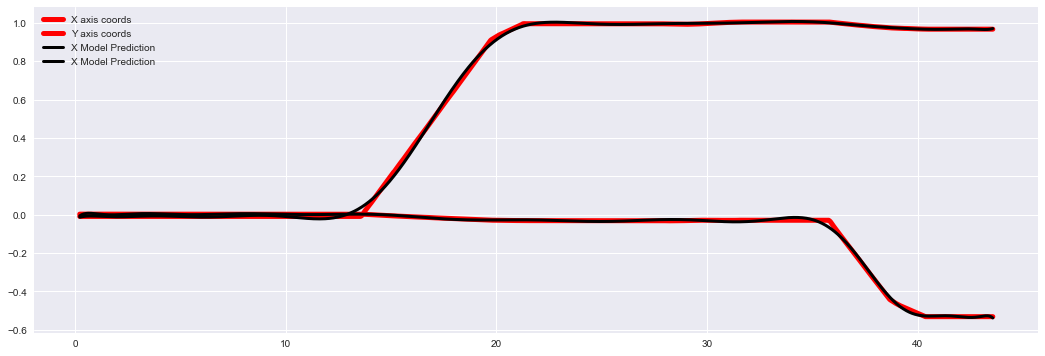

In [147]:
# Store data from Pandas to list
time_values = TF["TF_TIME"]
pos_x_values = TF["Translation X"]
pos_y_values = TF["Translation Y"]

# Plot original models
plt.figure(figsize = (18, 6))
plt.style.use('seaborn')
plt.plot(time_values, pos_x_values, c='red', label='X axis coords',linewidth=5.0)
plt.plot(time_values, pos_y_values, c='red', label='Y axis coords',linewidth=5.0)
plt.legend()

# Calculate and plot estimated models
#  First is a X axis prediction.
x_pos_model = np.poly1d(np.polyfit(time_values, pos_x_values, 20))
plt.plot(time_values, x_pos_model(time_values), c='black', label='X Model Prediction',linewidth=3.0)
plt.legend()

#  Second is a Y axis prediction.
y_pos_model = np.poly1d(np.polyfit(time_values, pos_y_values, 20))
plt.plot(time_values, y_pos_model(time_values), c='black', label='X Model Prediction',linewidth=3.0)
plt.legend()
plt.show()

We can see that red lines is the real representation of of coordinates and time, and the black lines is the predicted representation which is almost identical. Therefore,  these model can be used for transformation TF reading to the format that matches with IMU and Encoders format.

In the next step we are going to create a new Pandas data frame where we will store coordinate X and Y based on 
the timestamps from the IMU and models(from TF) created above.

In [148]:
# Create a new dataframe
df_for_predicted_XY = pd.DataFrame(columns=['TIME', 'position X', 'position Y'])
time_from_imu = list()
time_from_imu = imu["imu_TIME"]

# Fill in the first colum of the dataframe
df_for_predicted_XY["TIME"] = time_from_imu

# Calculate position X and store it
x_predicted = x_pos_model(time_from_imu)
df_for_predicted_XY['position X'] = x_predicted

# Calculate position Y and store it
y_predicted = y_pos_model(time_from_imu)
df_for_predicted_XY['position Y'] = y_predicted

### <div align="center">Visualize Predicted and Original Pos X,Y</div>

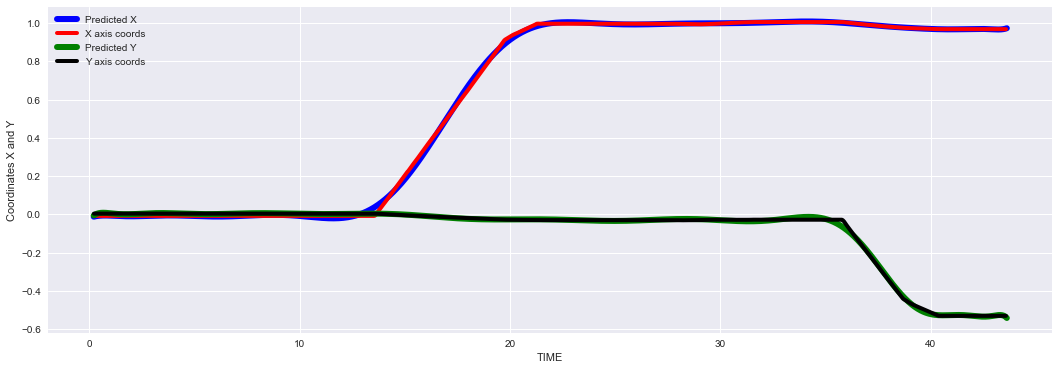

In [149]:
# Plotting
plt.figure(figsize = (18, 6))
plt.plot(time_from_imu, x_predicted, c='blue', label="Predicted X", linewidth=6.0) # Predicted readings
plt.plot(time_values, pos_x_values, c='red', label='X axis coords',linewidth=4.0) # Original readings
plt.xlabel("TIME")
plt.ylabel("Coordinates X and Y")
plt.legend(loc="upper left")
# plt.show()

# Plotting
# The scale is different THAT"S WHY from the first glance the polt might look weird.
# It's just  zoomed in.

# plt.figure(figsize = (18, 6))
plt.plot(time_from_imu, y_predicted, c='green', label="Predicted Y", linewidth=6.0) # Predicted readings
plt.plot(time_values, pos_y_values, c='black', label='Y axis coords',linewidth=4.0) # Original readings
plt.xlabel("TIME")
plt.ylabel("Coordinates X and Y")
plt.legend(loc="upper left")
plt.show()

##### As a result we have predicted(from TF) coordinates X and Y, that could be used with IMU and Encoder data in the Particle Filter while we're iterating over timestamps.

# <div align="center">Part 6. Orientation calculation</div>

In this part we calculate robot's headings. Raw data came from IMU unit. IMU doesn't give us a robot heading in eular angel like degree or radian. Robot heading presented in IMU is in the shape of quaternion.
The function below calculates radian from quaternion.

In [150]:
import math

def euler_from_quaternion(x, y, z, w):
    
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        
        # Standard math formulas implemented in python
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return  yaw_z # in radians




The next step is to do calculation and plot the result on the graph.

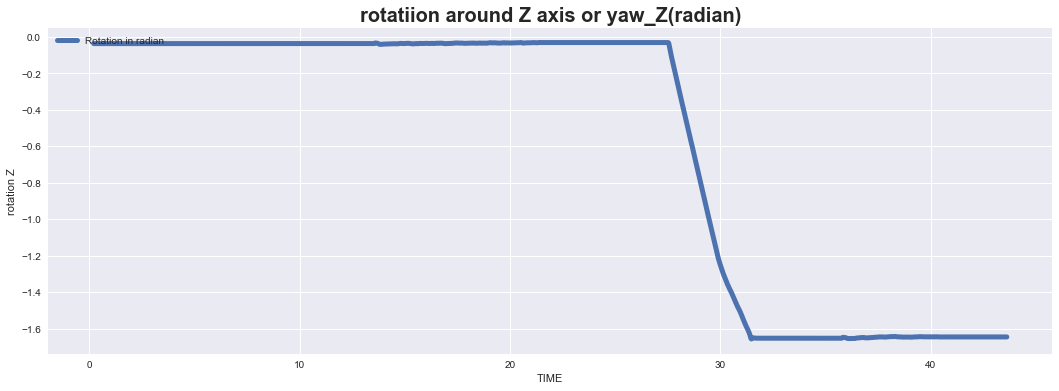

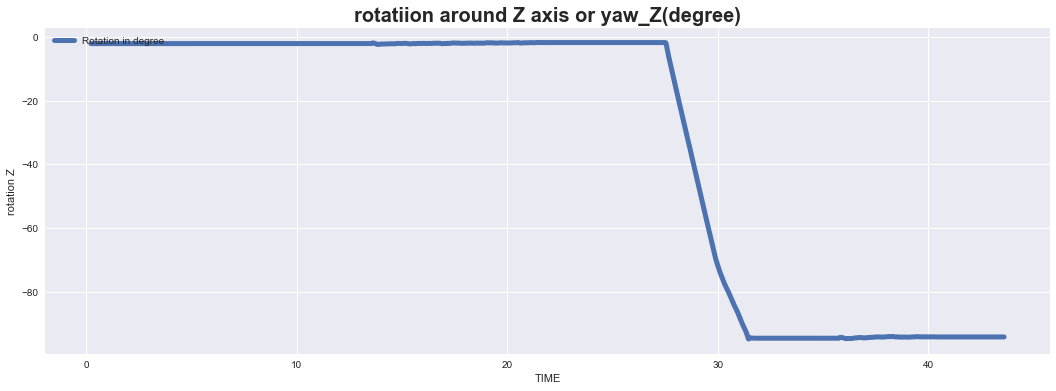

In [151]:
# This block does calculation of rotation and plot the results

# Number of rows
number_of_rows = len(imu_orientation_w)

yaw_z = [None]*number_of_rows
yaw_z_D = [None]*number_of_rows

# Iterate over number of rowns(readings)
for i in range(number_of_rows):  
    
    # Covert in radians using a function
    yaw_z[i] = euler_from_quaternion(imu_orientation_x[i], imu_orientation_y[i], imu_orientation_z[i], imu_orientation_w[i])
    
    # Covert in degrees using math
    yaw_z_D[i] = yaw_z[i] * 180/np.pi  
         

# Standard commands for plotting
plt.figure(figsize = (18, 6))
plt.plot(time_from_imu, yaw_z, label="Rotation in radian", linewidth=5.0)   # rotation in radian
plt.xlabel("TIME")
plt.ylabel("rotation Z")
plt.legend(loc="upper left")
plt.title("rotatiion around Z axis or yaw_Z(radian)", fontsize = 20, fontweight = "bold")
plt.show()

plt.figure(figsize = (18, 6))
plt.plot(time_from_imu, yaw_z_D, label="Rotation in degree", linewidth=5.0)   # rotation in degree
plt.xlabel("TIME")
plt.ylabel("rotation Z")
plt.legend(loc="upper left")
plt.title("rotatiion around Z axis or yaw_Z(degree)", fontsize = 20,fontweight = "bold")
plt.show()

In this graph shows the changes in the value of robot heading during 42 seconds of manuver.
Conclusions:
1. The command is 90 degree turning, but as it shows the robot has a small error in turning.
2. Heading is reading for using in Partcile Filter(PF).

# <div align="center">Part 7. Imu velocity</div>

We decided to use IMU sensor because it gives us acceleration and time stamps. By applying mathematical formula, we can calculate velocity: V = U + AT where - Initial velocity (U), acceleration (A), time (T) and  final velocity (V).

In [152]:
# The thoughtflow
# Create empty list where the accelaration would be stored.
robot_acc_y = list()
robot_acc_x = list()
robot_time = list()



number_of_rows = len(imu_orientation_w)
i = 0

# Iterare over each row of IMU Pandas Data Frame and store the values in the lists.
while i != number_of_rows:
    robot_acc_x.append(imu["imu_linear_acceleration_x"][i])
    robot_acc_y.append(imu["imu_linear_acceleration_y"][i])
    robot_time.append(imu["imu_TIME"][i])
    i += 1

# Conver lists into numpy array.
robot_acc_np_x = np.array(robot_acc_x)
robot_acc_np_y = np.array(robot_acc_y)
robot_time_np = np.array(robot_time)




# Create list of velocity X and Initial velocity is 0.
velocity_x = [0]

# J is the couter and we need it to skip the 0 index element.
j = 0
# Iterate over the list of acceleration and calculate velocity based on given formula
for acc in robot_acc_x:
    if j == 0:
        pass
    else:
        velocity_x.append(velocity_x[j-1] + acc * (robot_time_np[j]-robot_time_np[j-1])) # v = u + a*t
    j += 1 
    
# Convert list into the Panda Data Frame format.
imu['velocity_x'] = velocity_x


# VELOCITY Y - repeat the same logic as above.
j = 0
velocity_y = [0]

for acc in robot_acc_y:
    if j == 0:
        pass
    else:
        velocity_y.append(velocity_y[j-1] + acc * (robot_time_np[j]-robot_time_np[j-1])) # v = u + a*t
    j += 1 
imu['velocity_y'] = velocity_y


# Result velocity is calculated by using Pythagorean theorem
# Create empty list
result_velocity = list()

# Loop over velocities, apply formula c^2 = a^2 + b^2 and store in the list
for i in range(len(velocity_x)):
    result_velocity.append(np.sqrt(velocity_x[i]**2+velocity_y[i]**2))

# Convert list into the Panda Data Frame format.
imu['result_velocity'] = result_velocity


### <div align="center">Visualize Velocity, Acceleration</div>

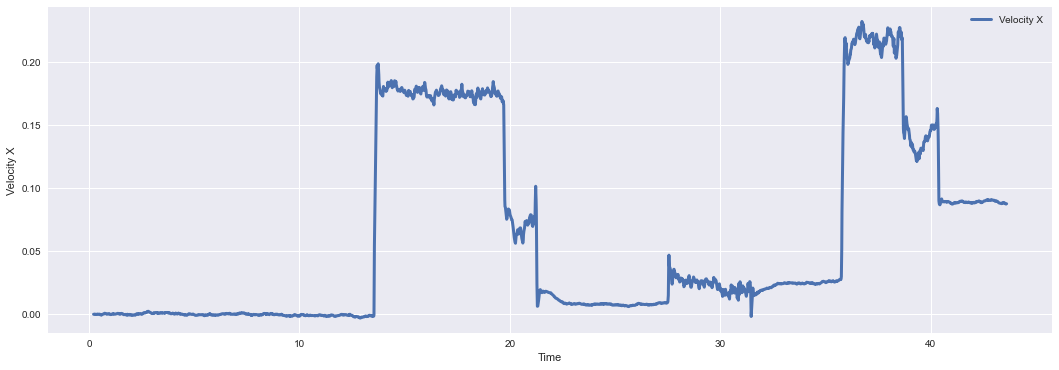

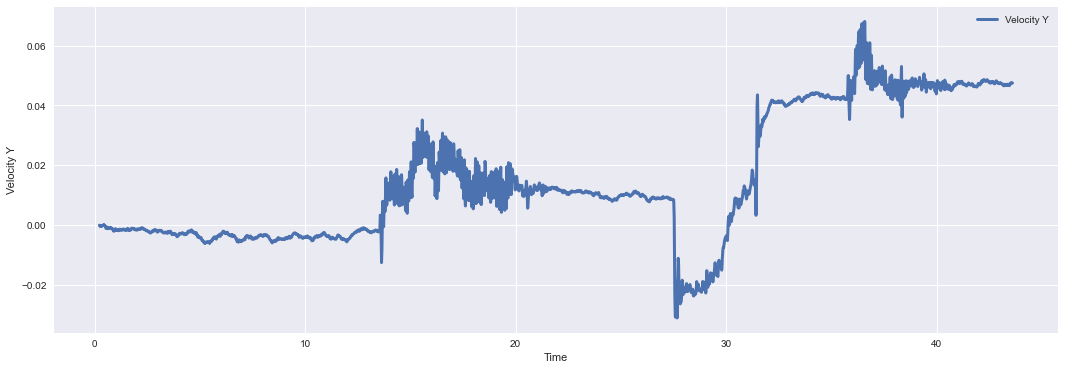

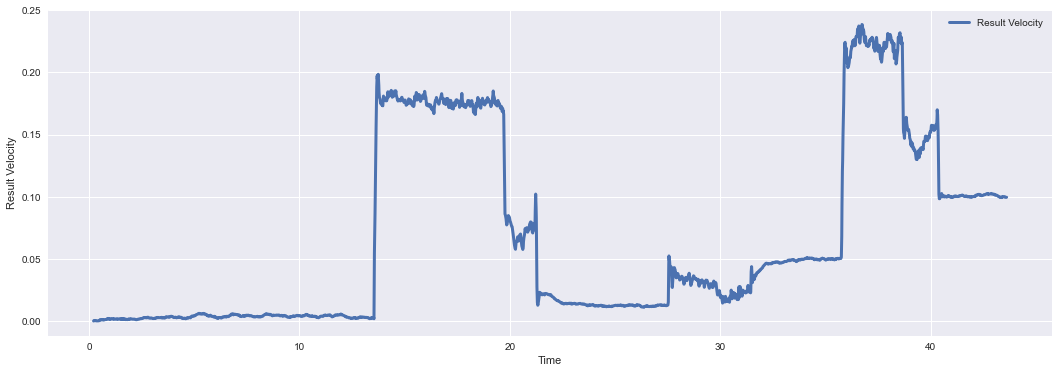

In [153]:
# Plot the Velocity X, Velocity Y, Result Velocity.

plt.figure(figsize = (18, 6))
plt.plot(robot_time_np, velocity_x, label='Velocity X', linewidth=3.0)
plt.xlabel("Time")
plt.ylabel("Velocity X")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize = (18, 6))
plt.style.use('seaborn')
plt.plot(robot_time_np, velocity_y, label='Velocity Y', linewidth=3.0)
plt.xlabel("Time")
plt.ylabel("Velocity Y")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize = (18, 6))
plt.style.use('seaborn')
plt.plot(robot_time_np, result_velocity, label='Result Velocity', linewidth=3.0)
plt.xlabel("Time")
plt.ylabel("Result Velocity")
plt.legend(loc="upper right")
plt.show()

###### As a result of plotting we can see that:
1. The Velocity X and Result Velocity are almost identical. 
2. The Velocity Y comparing to Velocity X is much smaller and we ussume that it take origins from the
vibration of the robot that might cased by the untiming rotation of the wheels or the roughness of the surface.

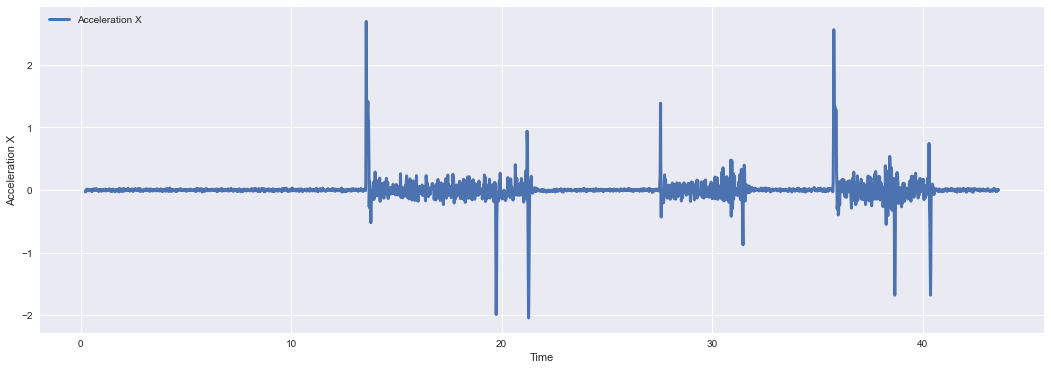

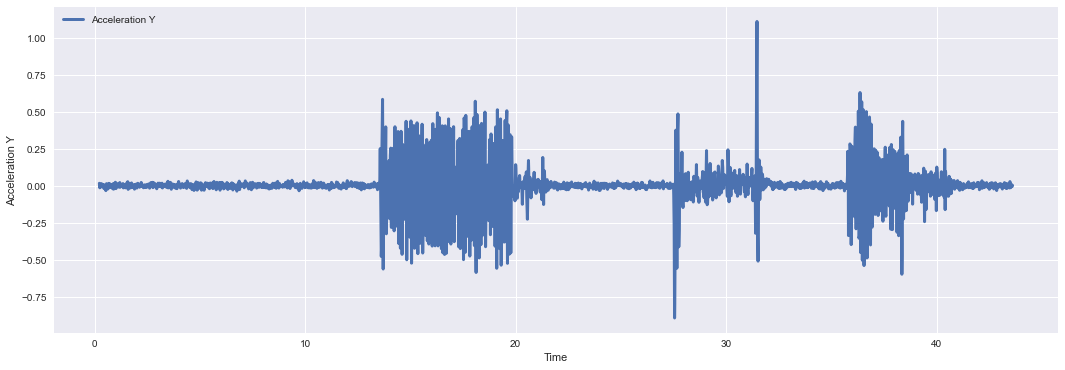

In [154]:
# Plot the Acceleration X, Acceleration Y, Result Acceleration.

plt.figure(figsize = (18, 6))
plt.plot(robot_time_np, robot_acc_np_x, label='Acceleration X', linewidth=3.0)
plt.xlabel("Time")
plt.ylabel("Acceleration X")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize = (18, 6))
plt.style.use('seaborn')
plt.plot(robot_time_np, robot_acc_np_y, label='Acceleration Y', linewidth=3.0)
plt.xlabel("Time")
plt.ylabel("Acceleration Y")
plt.legend(loc="upper left")
plt.show()

###### As a result of plotting we can see that:
1. Acceleration X repeats the pattern of Velocity X and much bigger comparing to Acceleration Y which is caused by vibration.


# <div align="center">Part 8. First particle filter (without error[without std])</div>

#### Experiment 1

Particle Filter(PF) assembling:
1. We define landmarks. The number and position of Non-physical landmarks
depend on: sensor accuracy, complexity of the environment and number of particles being used in PF.
Usually scientist and engineers begin with a small number.
2. Create uniform particles. Each particle is has  a weight, which represents the probability that the particle's state is the true state of the system.
3. Iterate over the prepared data from IMU and TF.
4. Predict the state of a system by using sensor data and particles.
5. Update. We  compare the measurements to the filter predicted state , then use this information to update the weights of each particle.
6. Resempling needed to prevent loss of diversity among particles.
7. Estimate. We calculate the state of the system, based on the set of particles and weights.
8. Plot.

final position error, variance:
	 [-0.82361662  0.60898012  0.33635595] [7.44859517e-06 1.03623380e-06 1.49291808e-05]


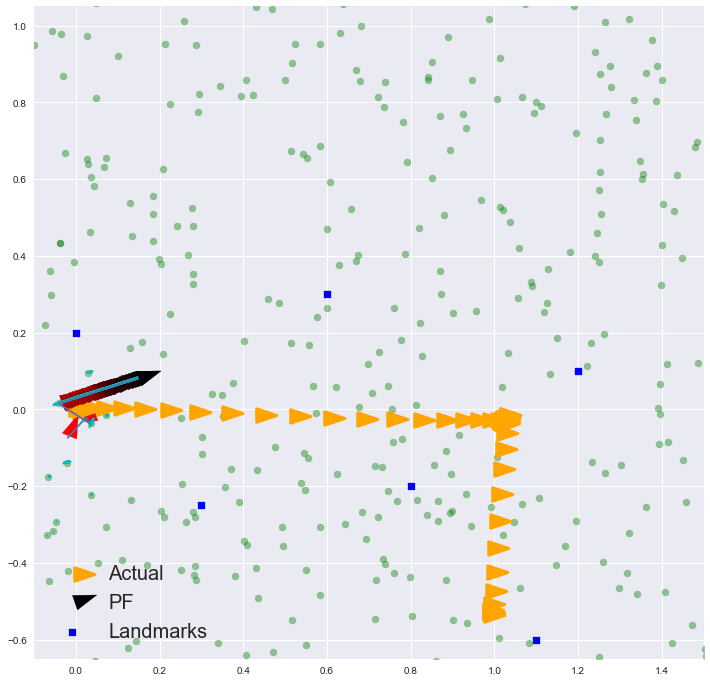

In [155]:
# Upload the libraries that are needed for PF to work.
import numpy as np
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats    
from numpy.random import seed


# Create a Particle Filter
# The concept and the part of the structure is taken from the lectures that was presented during DFA course.
# Besides that various online resources were used.

def particle_filter_0(N, sensor_std_err=.1, do_plot=True, plot_particles=False, xlim=(-0.1, 1.5), 
                      ylim=(-0.65, 1.05), initial_x=None,  velocity=0, rotation=0, landmarks = None, std_set=(0.001, 0.001)):
    
    # If landmarks None - Set the coordiante for the landmarks.
    if landmarks.all() == None:
        landmarks = np.array([[-1, -1],[-1,1],[1,1], [1,-1]])
#     landmarks = np.array([[0, 0.2],[1.2, 0.1],[0.3, -0.25], [0.6, 0.3],[0.8, -0.2], [1.1, -0.6]])
    
    # Assign a variable that stores number of landmarks
    num_of_landmarks = len(landmarks)
   
    # Create particles and weights
    # In our case we work with Uniform Particles
    particles = create_uniform_particles((-1, 2), (-1, 2), (0, 2*np.pi), N)
    
    # Create a variable weights.
    # If we have 1000 particles, then arrays shape is (1000) and each element equals [0.001 ... 0.001]
    weights = np.ones(N) / N


    # Assign the size of a frame for plotting
    plt.figure(figsize=(12, 12))
    
    # Plot particles 
    if plot_particles:
        # The "alpha" parameter is the transparency of the dots. Particles are slightly transparent.
        alpha = .4
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')

    # This is an array where we will store mean(after estimation) every iteration.
    mean_var = []
    
#     time_while    = list() # collect the time stamps in the while loop. We need the to for plotting in the next section.
    
    # If initialy the rotation is 0, then we create array of zeros and use it our iterations below
    if rotation == 0:
        rotation = np.zeros(number_of_rows)
    
    # Every 60 reading aproximately equals 1 second.
    # i is our 'flag' that will help us in iteration. 
    # In the end of each iteration we add to i +30.
    # Thus, our iteration equals around 0.5 second.
    i = 0
    while i < number_of_rows:
        
        # Delta time. Period of time between currant and previous timestamp-reading.
        if i == 0:
            del_T = 0
        else:
            del_T = robot_time_np[i] - robot_time_np[i-1]

        # The real position of the robot. Extracted from TF in-built function. 
        robot_pos = np.array([df_for_predicted_XY['position X'][i], df_for_predicted_XY['position Y'][i]])

        # The measurements taken by the robot.
        # Sensor error and random error are inculded.
        robot_measurments = (norm(landmarks - robot_pos, axis=1) + (randn(num_of_landmarks) * sensor_std_err))

        

        predict(particles, u=(rotation[i], velocity[i]), std=std_set, dt = del_T)


        # This algorithm is called Sequential Importance Sampling
        # Update function incorporate new measurement data into the filter's state estimate.
        # We  compare the measurements to the filter predicted state , then use this information to update the weights of each particle.
        update(particles, weights, z=robot_measurments, R=sensor_std_err, landmarks=landmarks)

        # Somethimes  the weights of the particles become very skewed
        # Thus, we use Resampling is needed to prevent loss of diversity among particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        # We calculate the state of the system, based on the set of particles and weights.
        # The output is mean and variance
        mu, var = estimate(particles, weights)

        # Store mean in the array
        mean_var.append(mu)

        # Plot particles
        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], color='c', marker=',', s=1)

        # Create a marker for the original position and heading of a robot.
        marker2, scale2 = gen_arrow_head_marker(rotation[i])
        markersize = 2000

        # Plot original position of a robot
        plot_one = plt.scatter(robot_pos[0], robot_pos[1], marker= marker2, s=(markersize*scale2), color='orange', lw=3)

        # Create a marker for the predictied position and heading of a robot.
        marker, scale = gen_arrow_head_marker(mu[2])
        markersize = 2500

        # Plot predicted position of a robot
        plot_two = plt.scatter(mu[0], mu[1], marker= marker,s=(markersize*scale), color=(1-i/number_of_rows, .0, 0.0)) # Here is actual position. But how is it calculated ?

#         time_while.append(time_from_imu[i]) # collect the time stamps in the while loop. We need the to for plotting in the next section.

        i += 30
    # Plot the landmarks
    for i in landmarks:
        plot_three = plt.scatter(i[0], i[1], marker='s', color='blue')

    # Change list to numpy array type
    mean_var = np.array(mean_var)
        
    
    # 
    plt.plot(mean_var[:, 0], mean_var[:, 1])
    plt.legend([plot_one, plot_two, plot_three], ['Actual', 'PF', 'Landmarks'], loc=3, numpoints=2, fontsize = 20)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([robot_pos[0], robot_pos[1], rotation[-1]]), var)
    plt.show()

# 6 landmarks around our path is decided to assign. Based on trials and errors.
landmarks_us = np.array([[0, 0.2],[1.2, 0.1],[0.3, -0.25], [0.6, 0.3],[0.8, -0.2], [1.1, -0.6]])
seed(1)
particle_filter_0(N=1000, plot_particles=True,  velocity = imu['velocity_x'], rotation = 0, landmarks=landmarks_us)



Conclusion: we can see that without given standard deviation in the predict function the localization is impossible. If we want Bayes algorithm work properly we need to add uncertainty. 


# <div align="center">Part 9. Second particle filter (IMU velocity)</div>

#### Experiment 2

Particle Filter same as in experiment one with uncertainty in the system.

final position error, variance:
	 [0.02049998 0.01943171 3.02393461] [1.06734840e-03 1.01252083e-03 1.96537932e+00]


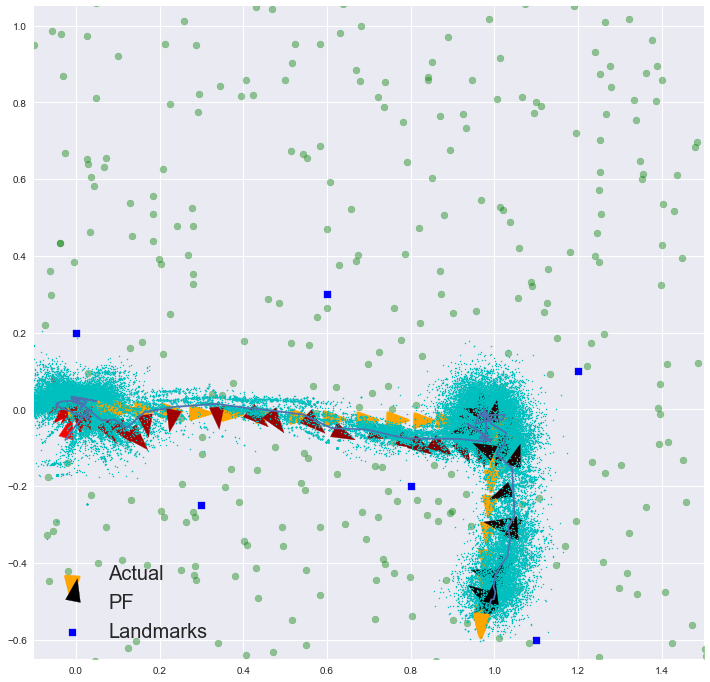

In [156]:
# Landmarks are the same. We add std_set in the particle - filter
# 6 landmarks around our path is decided to assign. Based on trials and errors.
# Standard deviation is decided to be taken as follows std_set = (.1, .03) based on observation of an experiments.
landmarks_us = np.array([[0, 0.2],[1.2, 0.1],[0.3, -0.25], [0.6, 0.3],[0.8, -0.2], [1.1, -0.6]])
seed(1)
particle_filter_0(N=1000, plot_particles=True,  velocity = imu['velocity_x'], rotation = yaw_z,
                  landmarks=landmarks_us, std_set = (.1, .03))





Conclusion - we can see that prediction work. We have some error in position and heading estimation. This error could be reduced by increasing the number of particles, use better resempling, fuse more sensors data.

# <div align="center">Part 10. Calculate velocity (wheel encoders)</div>

In the begining we only had data from IMU sensor which makes our localization solution vulnerable and not relible. 
If the sensors will start sending noisy signal, the robot would be lost. Therefore, we need to find one more source of data.
We can extract velocity from Wheel Encoders:
<div align="center">v = r * ω</div>
<div align="center">ω = radians per second (rad/s)</div>

<center><img src="three.jpeg"/></center>

We can see that the diameter is 72 mm. We will use it.
In the code below we will extract wheel velocity and calculate linear velocity based on data and formula above.

In [157]:
# Linear Velosity derived from wheel velocity.

# Prepare list for storing wheel velosity from Pandas
wh_vel_right = list()

wh_vel_right = wheels_velocity["wheel velocity right"] 

wh_vel_left = list()

wh_vel_left = wheels_velocity["wheel velocity left"] 

wh_vel_time = list()

wh_vel_time = wheels_velocity["wheels_velocity_TIME"] 
wh_vel_time_np = np.array(wh_vel_time) 

# Prepare list for storing newly calculated linear velocity
vel_right = list()
vel_left = list()

# Calculate linear velosity. Formula # v = r * ω
# Right wheel
for i in wh_vel_right:
    vel_right_var = (3.6 * i)/100   # We devide by 100 because originaly units measure in m/second, however, 
                                  # robot reading might be programmed to mm/second.
    vel_right.append(vel_right_var)
    
# Left_wheel
for i in wh_vel_left:
    vel_left_var = (3.6 * i)/100
    vel_left.append(vel_left_var)

# Here we find the mean velocity from 2 wheels.
# Create empty list
zero = list()

# Convert lists to numpy arrays
vel_left_np = np.array(vel_left)    
vel_right_np = np.array(vel_right)  

# Find mean.
zero.append(vel_left_np)
zero.append(vel_right_np)
wh_vel_mean = np.mean(zero,axis=0)




#### The result of data manipulation is better to analyze graphical. We plot IMU linear velocity and Encoders Linear Velocity.

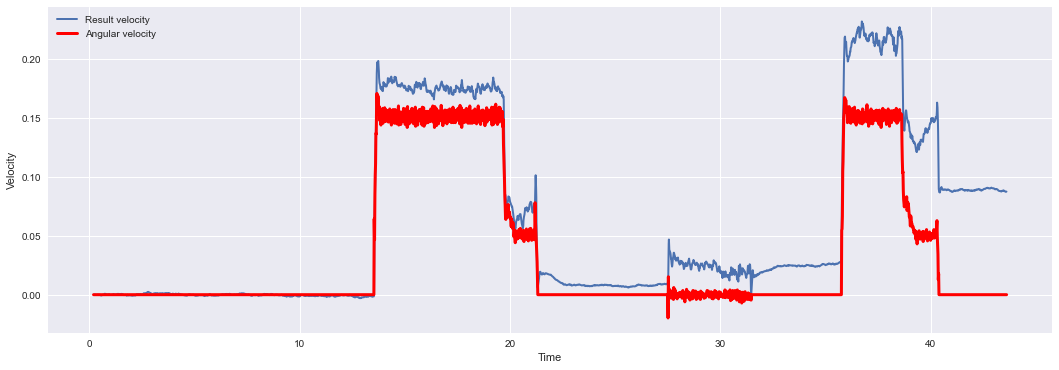

In [158]:
# Plotting and comparing the result velosity from IMU and Wheel Encoders

plt.figure(figsize = (18, 6))
plt.plot(robot_time_np, velocity_x, label="Result velocity", linewidth=2.0)   # IMU
plt.plot(wh_vel_time_np, wh_vel_mean, label="Angular velocity", color='r', linewidth=3.0)  # Wheel Encoders
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend(loc="upper left")
plt.show()

As a result we can see that Encoder Velocity is more stable and consistent. IMU velocity - while times goes the error is growing. We need to consider velocity fusion.

# <div align="center">Part 11. Third Particle filters (wheel encoders)</div>

#### Experiment 3

In the next experiment we will see the result of Particle Filter purely fed with Encoder Velocity in the predict function.

final position error, variance:
	 [0.01611539 0.01628259 4.92217289] [1.85102845e-03 1.45100721e-03 7.09292601e+00]


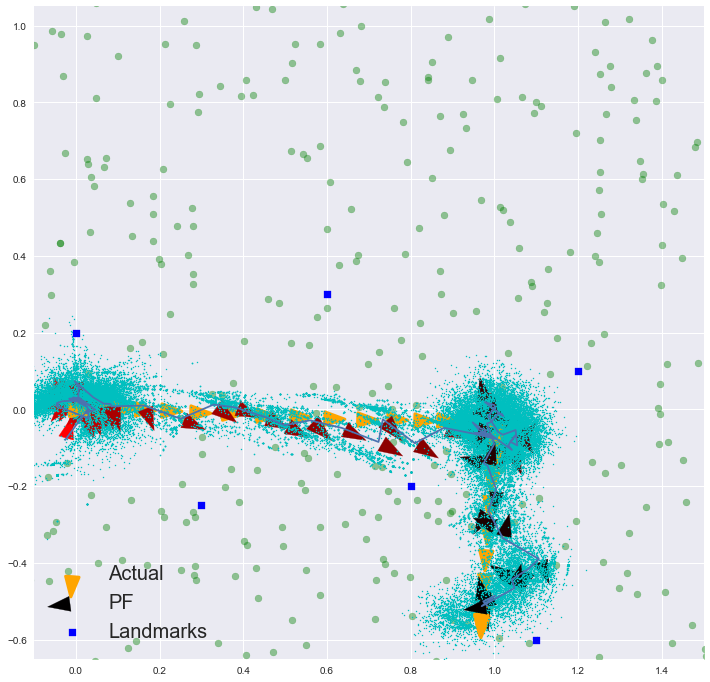

In [159]:
# Landmarks are the same. We add std_set in the particle - filter

landmarks_us = np.array([[0, 0.2],[1.2, 0.1],[0.3, -0.25], [0.6, 0.3],[0.8, -0.2], [1.1, -0.6]])
seed(1)
particle_filter_0(N=1000, plot_particles=True,  velocity = wh_vel_mean, rotation = yaw_z,
                  landmarks=landmarks_us, std_set = (.1, .03))

Conclusion - we can see that prediction work. We have some error in position and heading estimation. This error could be reduced by increasing the number of particles, use better resempling, fuse more sensors data.

# <div align="center">Part 12. Fusion (encoders and imu velocity) with Kalman Filter and implementation in the Particle Filter</div>

Our team decided to fuse IMU and Encoder velocity because it can help with:
1. Accuracy. We can improve overall accuracy of the velocity estimate.
2. Noise reduction. Reduce the noise of both sensors.
3. Handle sensor failure. If one of the sensors fails, fusing the measurements from the other sensor can help to maintain the accuracy of the velocity estimate.


According to the literature review robot's velocity might be changing over time (acceleration, deceleration). By using a Kalman filter to fuse IMU and encoder velocity data, we can potentially track the robot's velocity more accurately over time.
Kalman Filter is a good solution for noise reduction and increasing accuracy. What is more important our team is very exited with idea of apply two Filter in our project, this, we decided to fuse velocities with Kalman Filter.

### <div align="center">Kalman Filter</div>

The logic is follows - we run Particle Filter. Each iteration right before prediction we execute fusion_Kalman_Filter() function that return fused velocity.

#### Experiment 4

In [160]:
# This is a Kalman Filter
# We use this Kalman Filter Function just once in the Particle Filter before the predict function.
from filterpy.kalman import KalmanFilter # More information here https://filterpy.readthedocs.io/en/latest/index.html
# Here some other resources that were taken into considaration - https://thekalmanfilter.com/kalman-filter-python-example/

# Create a list where we store fused velocities
kf_vel = list() 

# Parameters of Kalman Filter
# dt: the time step between measurements
# imu_std_err: the standard error of the IMU velocity measurements
# wheel_std_err: the standard error of the wheel encoder velocity measurements
# num_timesteps: the number of time steps for which the filter will run
# imu_velocity: a list of IMU velocity measurements, one for each time step
# wheel_velocity: a list of wheel encoder velocity measurements, one for each time step


def fusion_Kalman_Filter(dt, imu_std_err, wheel_std_err, num_timesteps, imu_velocity,wheel_velocity):
    # Initialize Kalman filter
    # dim_x is 2 and dim_z is 2, which means that the state vector consists of 2 variables 
    # and the measurement vector consists of 2 variables.
    kf = KalmanFilter(dim_x=2, dim_z=2)

    # Set state transition matrix (A)
    # This matrix that describes how the state of the system changes over time
    kf.F = np.array([[1, dt],
                     [0, 1]])

    # Set process noise covariance matrix (Q)
    # This matrix describes the uncertainty in the system dynamics
    kf.Q = np.array([[0.1, 0.1],
                     [0.1, 0.1]])

    # Set measurement matrix (H)
    # This matrix transforms the predicted state of the system into the measurement space, 
    # so that the predicted state can be compared to the actual measurements.
    kf.H = np.array([[1, 0],
                     [0, 1]])

    # Set measurement noise covariance matrix (R)
    # This matrix is modeling the error or noise in the measurements, 
    # which can cause the estimated state of the system to deviate from the true state.
    kf.R = np.array([[imu_std_err**2, 0],
                     [0, wheel_std_err**2]])

    # Set initial state estimate (x) and covariance (P)
    # The state Estimate is a vector that contains the estimated values of the state variables of the system. 
    # The state estimate updates at each time step based on the predicted state and the measurements being taken.
    kf.x = np.array([[0],
                     [0]])
    # The state covariance matrix is a square matrix with dimensions equal to the number of state variables.
    # It is used to model the error or noise in the state estimate,
    # which can cause the estimated state to deviate from the true state.
    kf.P = np.array([[1, 0],
                     [0, 1]])

    # Loop through time steps
    for i in range(num_timesteps):
        # Predict state and covariance
        # We  predict the state of the system at the next time step, 
        # based on the current state estimate and the state transition matrix.
        kf.predict()

        # Fusion measurements
        # The Kalman filter uses this new measurement data, along with its internal state estimate and 
        # covariance matrix, to update its estimate of the true velocity.
        # This update is performed using the measurement matrix, measurement noise covariance matrix, and state transition matrix.
        kf.update(np.array([[imu_velocity], [wheel_velocity]]))

        # Get estimated state (x)
        # The kf.x[0, 0] expression returns the first element in the first column of the state estimate, in our case it is estimated velocity.
        velocity_estimate = kf.x[0, 0]
        kf_vel.append(velocity_estimate)
        
        return velocity_estimate


### <div align="center">Add Error Propagation (coding)</div>

In this specific case the Particle Filter should be modified.
Besides implementation of Kalman Filter we add lines of code to calculate **ERROR PROPAGATION**.
In the end we plot and analyze Error Propagation.

In [161]:
# The concept and the part of the structure is taken from the lectures that was presented during DFA course.
# Besides that various online resources were used.

def PF_plus_fusion_with_KalmanFilter(N, sensor_std_err=.1, do_plot=True, plot_particles=False, xlim=(-0.1, 1.5), 
                      ylim=(-0.65, 1.05), initial_x=None,  imu_vel=0, encoder_vel=0, rotation=0, landmarks = None, std_set=(0.001, 0.001)):
    
    # If landmarks None - Set the coordiante for the landmarks.
    if landmarks.any() == None:
        landmarks = np.array([[-1, -1],[-1,1],[1,1], [1,-1]])
#     landmarks = np.array([[0, 0.2],[1.2, 0.1],[0.3, -0.25], [0.6, 0.3],[0.8, -0.2], [1.1, -0.6]])
    
    # Assign a variable that stores number of landmarks
    num_of_landmarks = len(landmarks)
   
    # Create particles and weights
    # In our case we work with Uniform Particles
    particles = create_uniform_particles((-1, 2), (-1, 2), (0, 2*np.pi), N)
    
    # Create a variable weights.
    # If we have 1000 particles, then arrays shape is (1000) and each element equals [0.001 ... 0.001]
    weights = np.ones(N) / N


    # Assign the size of a frame for plotting
    plt.figure(figsize=(12, 12))
    
    # Plot particles 
    if plot_particles:
        # The "alpha" parameter is the transparency of the dots. Particles are slightly transparent.
        alpha = .4
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')

    # This is an array where we will store mean(after estimation) every iteration.
    mean_var = []
    # If initialy the rotation is 0, then we create array of zeros and use it our iterations below
    if rotation == 0:
        rotation = np.zeros(number_of_rows)
    
    # Every 60 reading aproximately equals 1 second.
    # i is our 'flag' that will help us in iteration. 
    # In the end of each iteration we add to i +30.
    # Thus, our iteration equals around 0.5 second.
    i = 0
    
    ########################################
    # NEW LINES FOR ERROR PROPAGATION
    j=0
    errors=[None]*91    #this variable is used to store the norme of every mu with actual position of robot at that moment
    ########################################
    
    while i < number_of_rows:
        
        # Delta time. Period of time between currant and previous timestamp-reading.
        if i == 0:
            del_T = 0
        else:
            del_T = robot_time_np[i] - robot_time_np[i-1]

        # The real position of the robot. Extracted from TF in-built function. 
        robot_pos = np.array([df_for_predicted_XY['position X'][i], df_for_predicted_XY['position Y'][i]])

        # The measurements taken by the robot.
        # Sensor error and random error are inculded.
        robot_measurments = (norm(landmarks - robot_pos, axis=1) + (randn(num_of_landmarks) * sensor_std_err))

        ########################################
        # This is our Fusion in the Kalman Filter
        velocity_estimate = fusion_Kalman_Filter(del_T, imu_std_err, wheel_std_err, number_of_rows, imu_vel[i], encoder_vel[i])
        ########################################
        
        # # We  predict the state of the system at the next time step
        predict(particles, u=(rotation[i], velocity_estimate), std=std_set, dt = del_T)


        # This algorithm is called Sequential Importance Sampling
        # Update function incorporate new measurement data into the filter's state estimate.
        # We  compare the measurements to the filter predicted state , then use this information to update the weights of each particle.
        update(particles, weights, z=robot_measurments, R=sensor_std_err, landmarks=landmarks)

        # Somethimes  the weights of the particles become very skewed
        # Thus, we use Resampling is needed to prevent loss of diversity among particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        # We calculate the state of the system, based on the set of particles and weights.
        # The output is mean and variance
        mu, var = estimate(particles, weights)

        # Store mean in the array
        mean_var.append(mu)

        # Plot particles
        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], color='c', marker=',', s=1)

        # Create a marker for the original position and heading of a robot.
        marker2, scale2 = gen_arrow_head_marker(rotation[i])
        markersize = 2000

        # Plot original position of a robot
        plot_one = plt.scatter(robot_pos[0], robot_pos[1], marker= marker2, s=(markersize*scale2), color='orange', lw=3)

        # Create a marker for the predictied position and heading of a robot.
        marker, scale = gen_arrow_head_marker(mu[2])
        markersize = 2500

        # Plot predicted position of a robot
        plot_two = plt.scatter(mu[0], mu[1], marker= marker,s=(markersize*scale), color=(1-i/number_of_rows, .0, 0.0)) # Here is actual position. But how is it calculated ?

        time_while.append(time_from_imu[i]) # collect the time stamps in the while loop. We need the to for plotting in the next section.
        
        ####################
        # NEW LINES FOR ERROR PROPAGATION
        errors[j] = np.linalg.norm(mu[0:2] - robot_pos)  #calculate the norm of our mu and actual position of the robot
        j+=1
        ####################
        
        i += 30
    # Plot the landmarks
    for i in landmarks:
        plot_three = plt.scatter(i[0], i[1], marker='s', color='blue')

    # Change list to numpy array type
    mean_var = np.array(mean_var)
        
    
    # 
    plt.plot(mean_var[:, 0], mean_var[:, 1])
    plt.legend([plot_one, plot_two, plot_three], ['Actual', 'PF', 'Landmarks'], loc=3, numpoints=2, fontsize = 20)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([robot_pos[0], robot_pos[1], rotation[-1]]), var)
    plt.show()
    
    ####################
    plt.plot(errors, label='error of estimation by PF', linewidth = 2)
    plt.xlabel('estimation number')
    plt.ylabel('error(cm)')
    plt.legend(loc="upper left")
    plt.title('error of estimation by PF', fontsize = 20, fontweight = "bold")
    plt.show()
    total_process_error = sum(errors)      #it shows that how much far is our gusses from actual position of robot when our PF works.
    print("final position error = ",errors[-1])
    print("total_process_error=",total_process_error)
    ####################

final position error, variance:
	 [3.91871307e-03 5.61595831e-03 5.73228951e+00] [1.36081952e-03 1.04400447e-03 7.45743666e+00]


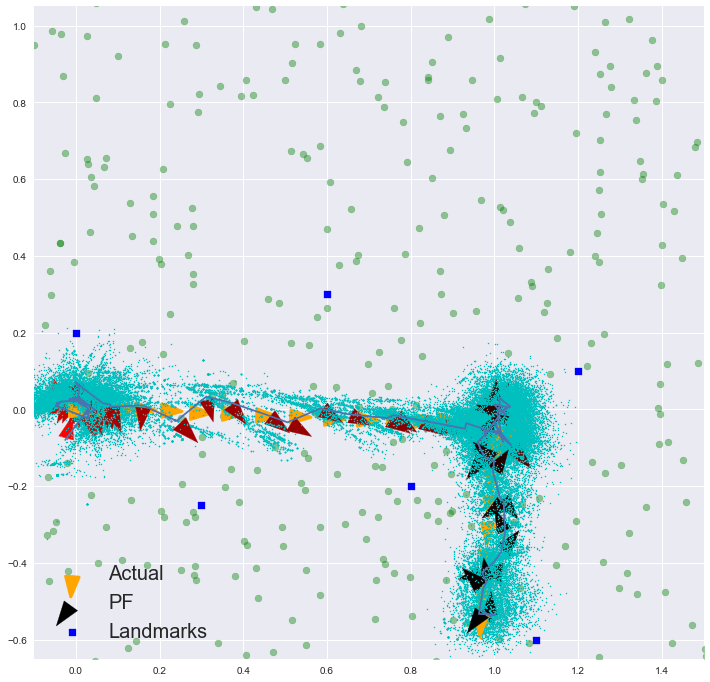

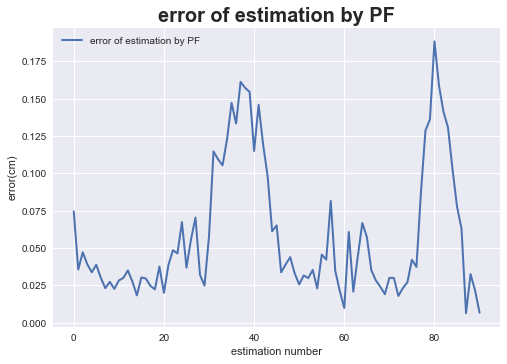

final position error =  0.006848014300939335
total_process_error= 5.345139089791631


In [162]:
time_while    = list() # collect the time stamps in the while loop. We need the to for plotting in the next section.
mean_vel      = list()
imu_std_err   = 0.4 # Due to graph observation given in section 11, we think that sensors has a large error
wheel_std_err = 0.1

# 6 landmarks around our path is decided to assign. Based on trials and errors.
# Standard deviation is decided to be taken as follows std_set = (.1, .03) based on observation of an experiments.
landmarks_us = np.array([[0, 0.2],[1.2, 0.1],[0.3, -0.25], [0.6, 0.3],[0.8, -0.2], [1.1, -0.6]])
seed(1)
PF_plus_fusion_with_KalmanFilter(N=1000, plot_particles=True,  imu_vel = imu['velocity_x'], encoder_vel = wh_vel_mean, 
                                 rotation=yaw_z, landmarks = landmarks_us, std_set = (.1, .03))



As a result we can see that final position and heading is precise. Predicted X and Y coordinates smaller than previous verision of the experiment. 

Let pot IMU, Encoder and Fused velocity and observe them graphically.

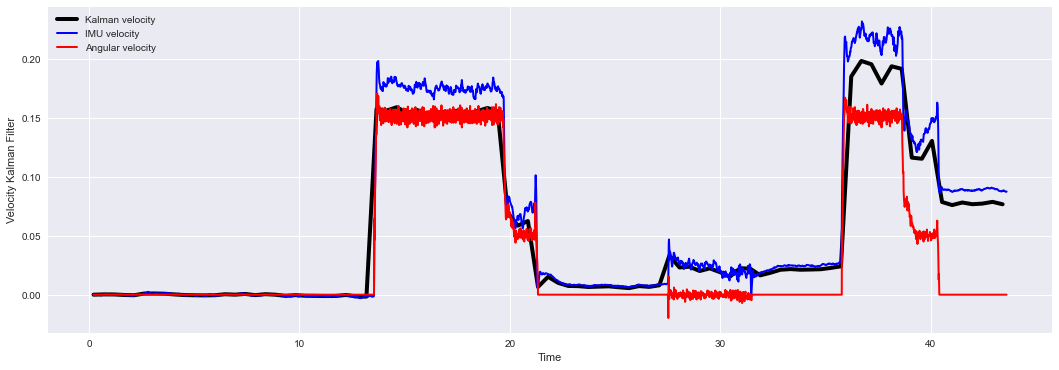

In [163]:
# Here whe Plot IMU, Encoder and fused speed.

plt.figure(figsize = (18, 6))
plt.plot(time_while, kf_vel, label="Kalman velocity", color='black', linewidth=4.0)
plt.plot(robot_time_np, velocity_x, label="IMU velocity", color='blue', linewidth=2.0)   # IMU
plt.plot(robot_time_np, wh_vel_mean[:2713], label="Angular velocity", color='r', linewidth=2.0)  # Wheel Encoders
plt.xlabel("Time")
plt.ylabel("Velocity Kalman Filter")
plt.legend(loc="upper left")
plt.show()

The black line is the fused velocity that shows more flexible and adaptive pattern.



The results of the last version of the particle filter in combination with the kalman filter that fused the IMU and encoder
velocities and used them to create a position estimate showed
promising results. The results of comparing the estimated
position using the particle filter to the actual position given
by tf function showed a difference of:
<div align="center">3.91871307e − 03, 5.61595831e − 03, 5.73228951e + 00</div>

This shows the difference in x and y positioning and z
orientation. The results of position are very good as the
difference between calculated position and real position is
0.00392m or 3.92mm in x direction and 0.00562m or 5.62mm
in y direction. The orientation predicted was 5.73 radians or
328°. In figure 10 we can see the actual position (orange
arrow) plotted next to the predicted position (black arrow).
The presented orientation of 328° is relative to the actual
last position of the robot. Since the actual last position of
the robot is considered to be 0° (or 360°) that means the
difference in estimation is about 32°, which matches the
offset visible in figure 10. However, throughout the particle
filter process some false orientations are visible. Despite the
final predicted orientation always being close to the actual
orientation, further improvements could be made to retrieve
more accurate readings.

# <div align="center">Part 13. Error propagation</div>

 The process of error propagation is an important aspect of the particle filter algorithm because it helps to continuously improve the estimate of the state of the system over time as new information is acquired. In this experiment we define the critical numbers for the sensors errors and ploted them.

#### Experiment 5

final position error, variance:
	 [-0.16196908  0.17826119  4.75359205] [0.00942472 0.00982591 3.20866557]


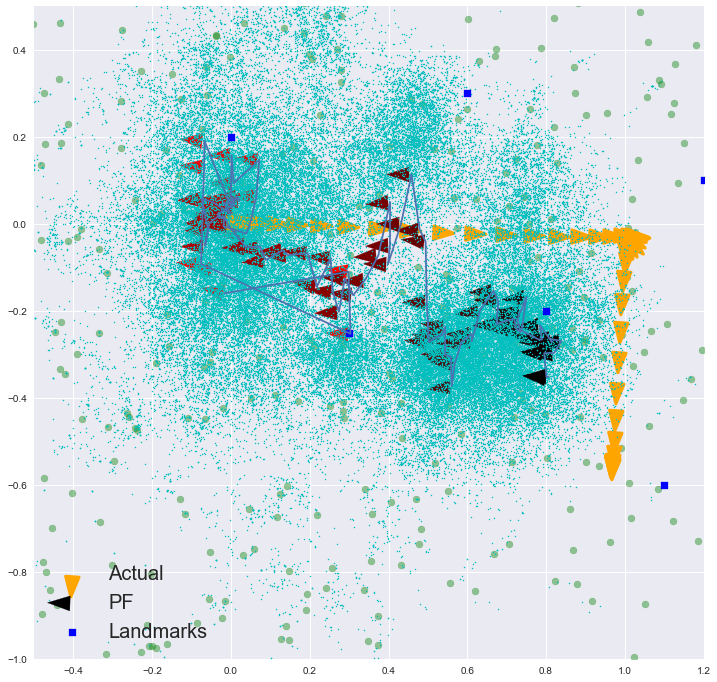

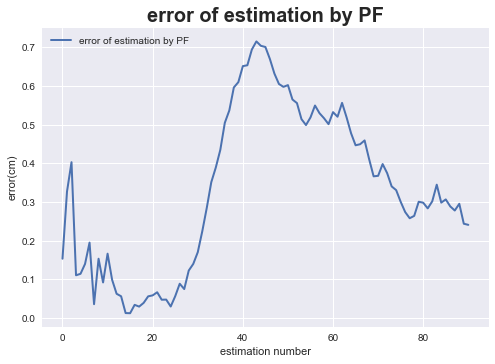

final position error =  0.24085479615632518
total_process_error= 30.226782365565324


In [164]:
seed(1)
PF_plus_fusion_with_KalmanFilter(N=1000, sensor_std_err=.7, plot_particles=True, xlim=(-.5, 1.2), ylim=(-1, .5), imu_vel = imu['velocity_x'], encoder_vel = wh_vel_mean, 
                                 rotation=yaw_z, landmarks = landmarks_us, std_set = (.7, .03))

In this part, to check the effects of various errors and also to investigate the effect of changing the filter parameters on the output, we define the variable “errors” and store all the distances of the means’ calculated by the filter with the actual position of the robot in the corresponding times. Finally, we sum the total values of these errors for each group of different inputs and store the result in the “total_process_error” variable. The data obtained in 9 cases by entering different values of error for the external sensor and error for calculating the speed and rotation of the robot as well as for changing the parameter of the number of particles are shown in the table below.
For example, according to the row marked in red in the table, we find that with the increase in the error value of the external sensor and the error in the rotation of the robot, the overall error of the filter, despite the constant number of particles and the error in calculating the speed along the path, increased greatly and even the final point Calculated by the filter in this case is 24 cm away from its actual location.


<center><img src="error.png"/></center>




# <div align="center">Part 14. Conclusion</div>

The created jupyter notebook file presents a method to use
bayesian probability and data fusion to calculate and predict
the localization of a create3 robot. The data from relevant
sensors was successfully extracted and displayed. The data
from the IMU and the wheel encoders was successfully fused
into a position estimate, and the particle filter was successfully
applied to generate a localization for the robot based on
generated landmark data. The particle filter compares the
generated particles to the readings from the existing odometry
(TF) and the results show a very realistic prediction, proving
the applied concepts.